In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
import holidays
from sklearn.metrics import mean_absolute_percentage_error
import optuna

In [2]:
os.chdir('..')

In [3]:
sample_submission = pd.read_csv('./data/sample_submission.csv')
test = pd.read_csv('./data/test.csv')
train = pd.read_csv('./data/train.csv')

In [4]:
train.shape

(70128, 6)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   row_id    70128 non-null  int64 
 1   date      70128 non-null  object
 2   country   70128 non-null  object
 3   store     70128 non-null  object
 4   product   70128 non-null  object
 5   num_sold  70128 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 3.2+ MB


In [6]:
train.head()

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [7]:
train = train.assign(date=lambda df_ : pd.to_datetime(df_.date))
test = test.assign(date=lambda df_ : pd.to_datetime(df_.date))

In [8]:
print(f"Date in train goes from {min(train.date)} to {max(train.date)}")

Date in train goes from 2017-01-01 00:00:00 to 2020-12-31 00:00:00


In [9]:
print(f"Date in test goes from {min(test.date)} to {max(test.date)}")

Date in test goes from 2021-01-01 00:00:00 to 2021-12-31 00:00:00


In [10]:
train.country.value_counts()

Belgium    11688
France     11688
Germany    11688
Italy      11688
Poland     11688
Spain      11688
Name: country, dtype: int64

In [11]:
train.groupby(['country','store']).product.count()

country  store     
Belgium  KaggleMart    5844
         KaggleRama    5844
France   KaggleMart    5844
         KaggleRama    5844
Germany  KaggleMart    5844
         KaggleRama    5844
Italy    KaggleMart    5844
         KaggleRama    5844
Poland   KaggleMart    5844
         KaggleRama    5844
Spain    KaggleMart    5844
         KaggleRama    5844
Name: product, dtype: int64

In [12]:
train.store.value_counts()

KaggleMart    35064
KaggleRama    35064
Name: store, dtype: int64

In [13]:
train['product'].value_counts()

Kaggle Advanced Techniques          17532
Kaggle Getting Started              17532
Kaggle Recipe Book                  17532
Kaggle for Kids: One Smart Goose    17532
Name: product, dtype: int64

In [14]:
train.groupby(['store','product']).product.count()

store       product                         
KaggleMart  Kaggle Advanced Techniques          8766
            Kaggle Getting Started              8766
            Kaggle Recipe Book                  8766
            Kaggle for Kids: One Smart Goose    8766
KaggleRama  Kaggle Advanced Techniques          8766
            Kaggle Getting Started              8766
            Kaggle Recipe Book                  8766
            Kaggle for Kids: One Smart Goose    8766
Name: product, dtype: int64

# One product in different countries in one store series

In [15]:
def country_cuadraplot(df, country, products, color):
    
    one_series_ex = df[(df.country == country) & 
                      (df.store == 'KaggleMart') & 
                      (df['product'] == products[0])]

    second_series_ex = df[(df.country == country) & 
                      (df.store == 'KaggleMart') & 
                      (df['product'] == products[1])]

    third_series_ex = df[(df.country == country) & 
                          (df.store == 'KaggleRama') & 
                          (df['product'] == products[0])]

    fourth_series_ex = df[(df.country == country) & 
                          (df.store == 'KaggleRama') & 
                          (df['product'] == products[1])]
    
    figure, axis = plt.subplots(2, 2, figsize=(16, 12))
    
    axis[0, 0].plot(one_series_ex.date, one_series_ex.num_sold, color=color)
    axis[0, 0].set_title(f"{country} - KaggleMart - {products[0]}")

    # For Cosine Function
    axis[0, 1].plot(second_series_ex.date, second_series_ex.num_sold, color=color)
    axis[0, 1].set_title(f"{country} - KaggleMart - {products[1]}")

    # For Tangent Function
    axis[1, 0].plot(third_series_ex.date, third_series_ex.num_sold, color=color)
    axis[1, 0].set_title(f"{country} - KaggleRama - {products[0]}")

    # For Tanh Function
    axis[1, 1].plot(fourth_series_ex.date, fourth_series_ex.num_sold, color=color)
    axis[1, 1].set_title(f"{country} - KaggleRama - {products[1]}")
                
    plt.show() 

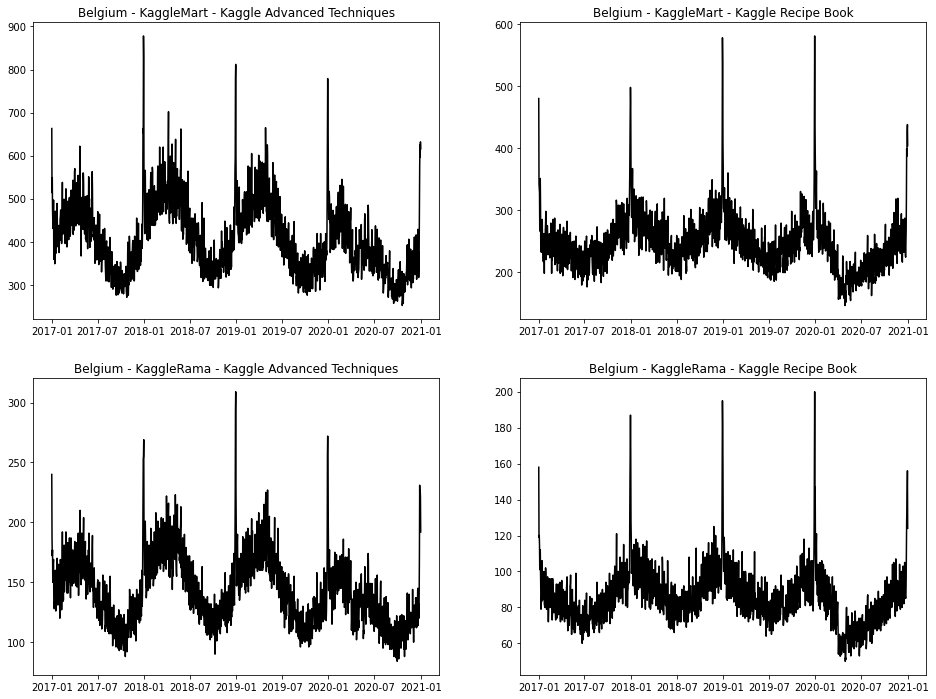

In [16]:
country_cuadraplot(train, 'Belgium', ['Kaggle Advanced Techniques', 'Kaggle Recipe Book'] , color='black')  

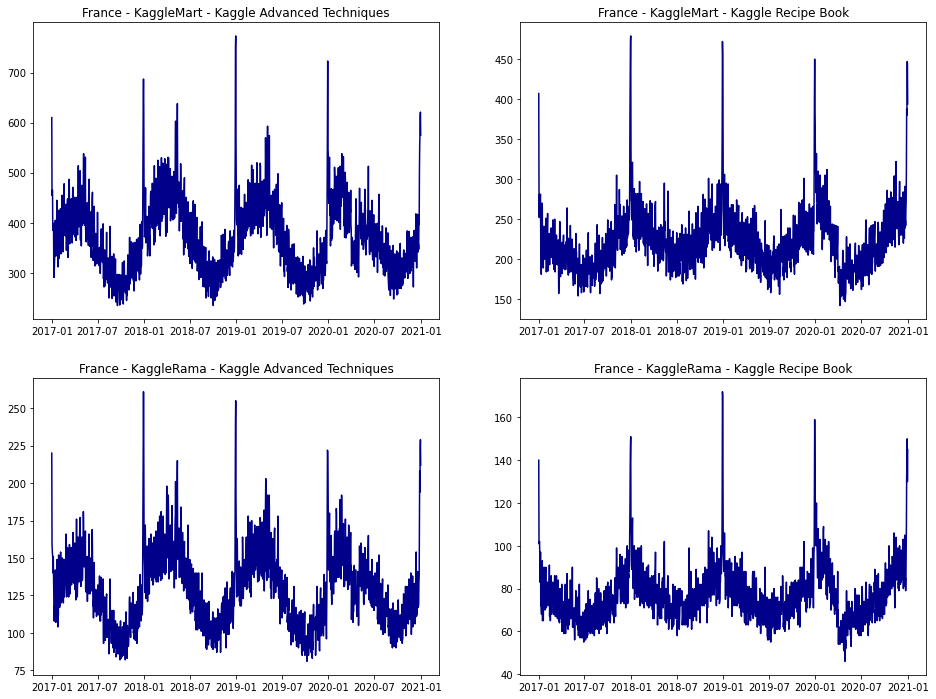

In [17]:
country_cuadraplot(train, 'France', ['Kaggle Advanced Techniques', 'Kaggle Recipe Book'] , color='darkblue')  

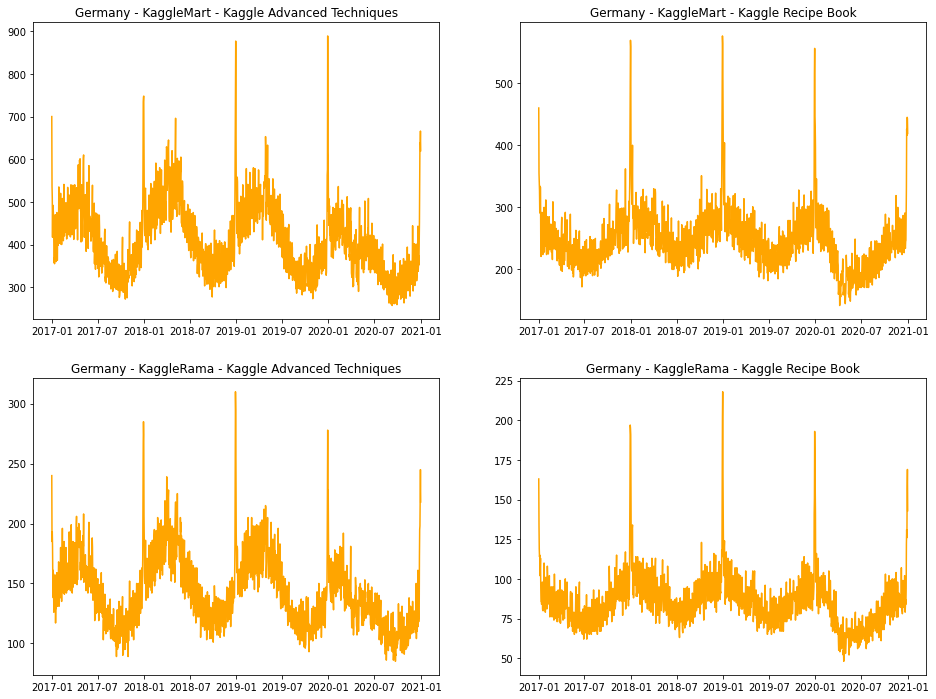

In [18]:
country_cuadraplot(train, 'Germany', ['Kaggle Advanced Techniques', 'Kaggle Recipe Book'] , color='orange')  

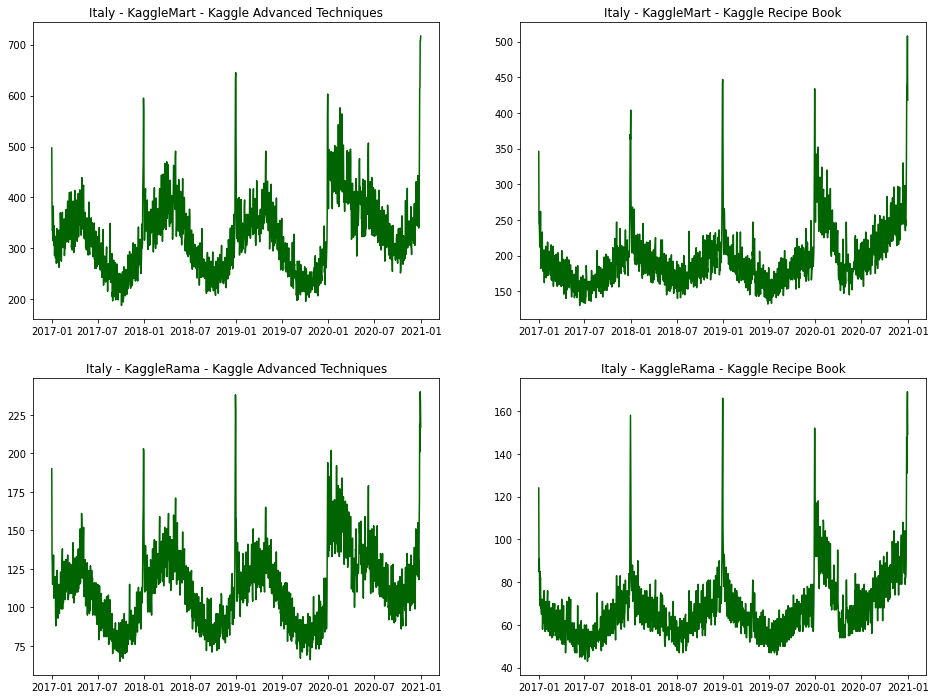

In [19]:
country_cuadraplot(train, 'Italy', ['Kaggle Advanced Techniques', 'Kaggle Recipe Book'] , color='darkgreen')  

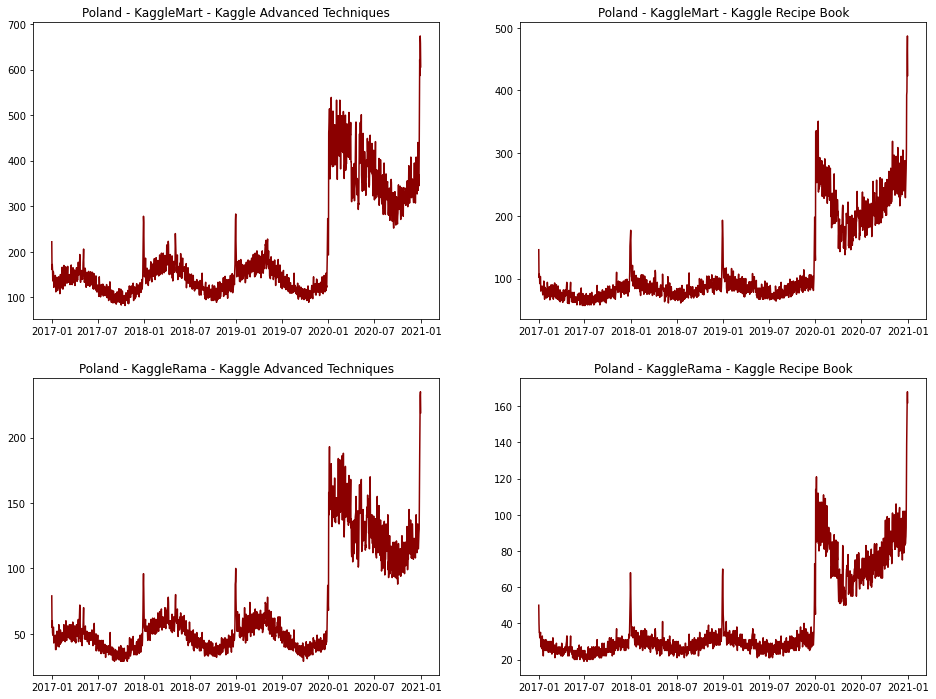

In [20]:
country_cuadraplot(train, 'Poland', ['Kaggle Advanced Techniques', 'Kaggle Recipe Book'] , color='darkred')  

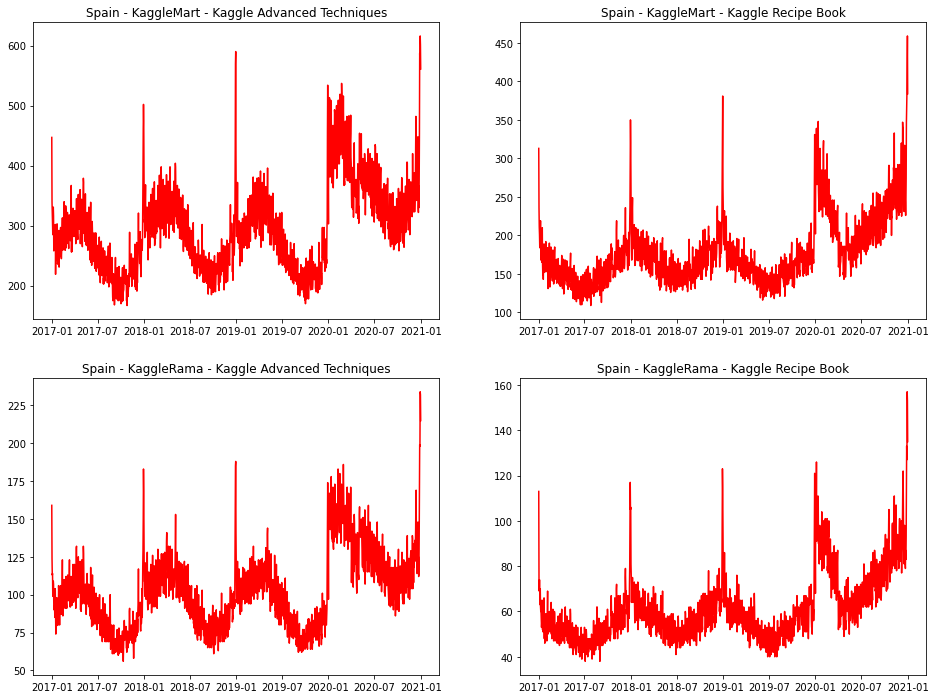

In [21]:
country_cuadraplot(train, 'Spain', ['Kaggle Advanced Techniques', 'Kaggle Recipe Book'] , color='red')  

In [22]:
train.head()

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


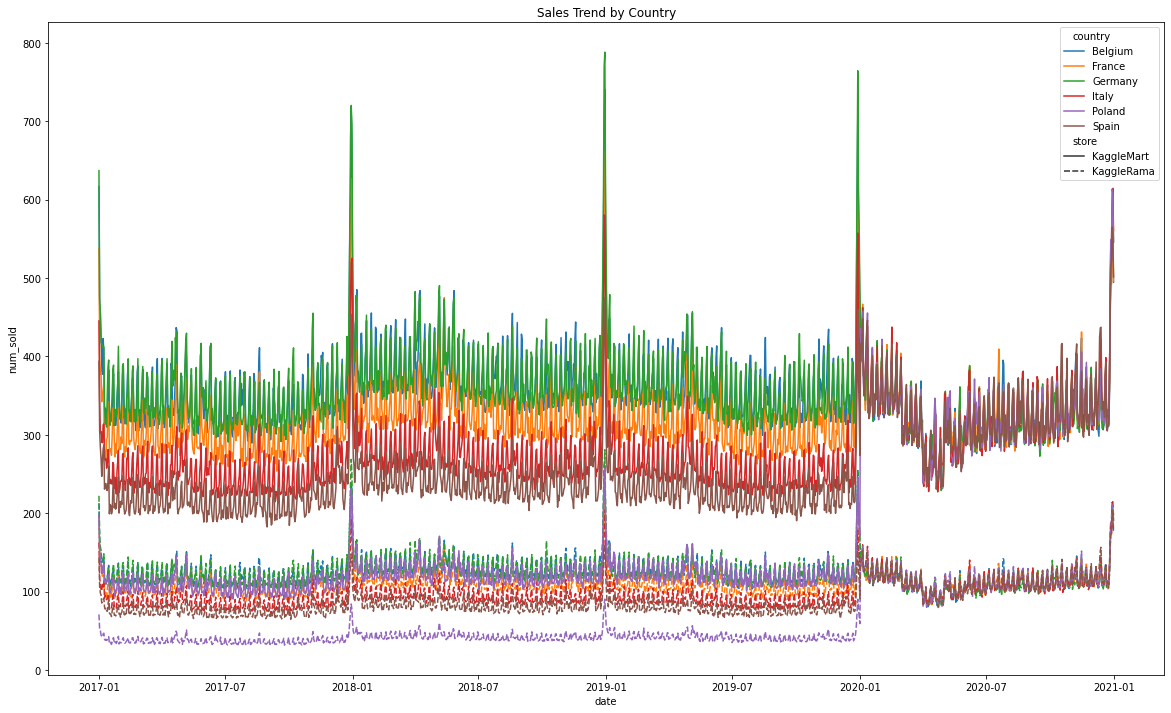

In [34]:
plt.figure(figsize=(20,12))
sns.lineplot(data=train,x='date',y='num_sold',hue=train.country,style="store",ci=None)
plt.title("Sales Trend by Country")
plt.show()

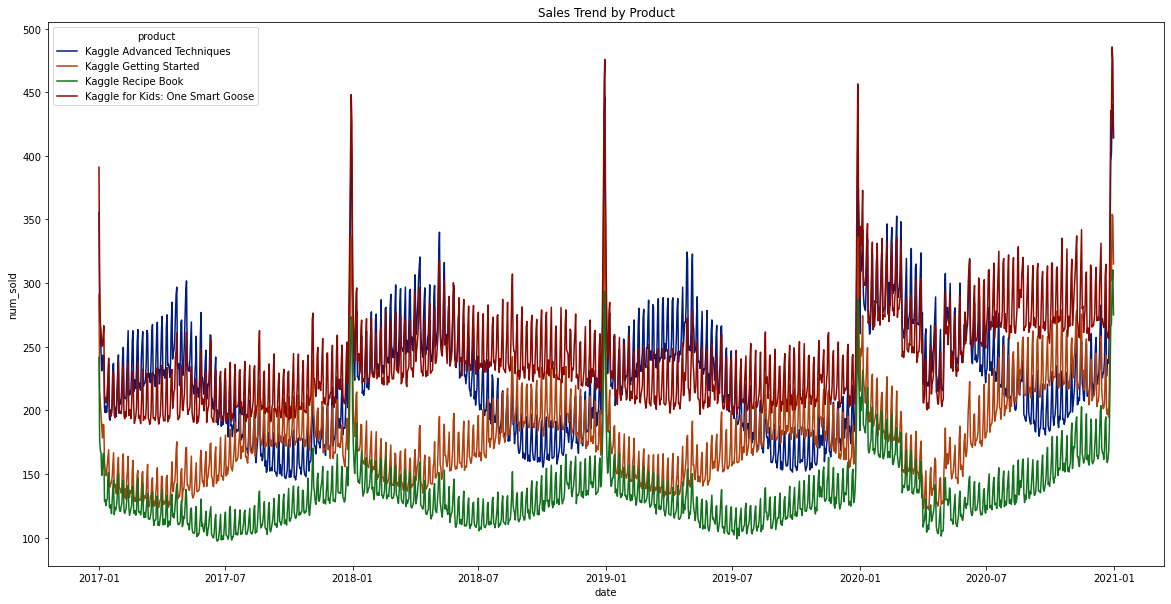

In [36]:
plt.figure(figsize=(20,10))
sns.lineplot(data=train,x='date',y='num_sold',hue='product',palette='dark',ci=None)
plt.title("Sales Trend by Product")
plt.show()

In [37]:
product_sales = train.groupby(['date', 'product']).sum().reset_index()

In [38]:
product_ratio_daily = product_sales.pivot(index="date", columns="product", values="num_sold")
product_ratio_daily = product_ratio_daily.apply(lambda x: x/x.sum(),axis=1)
product_ratio_daily = product_ratio_daily.stack().rename("ratios").reset_index()


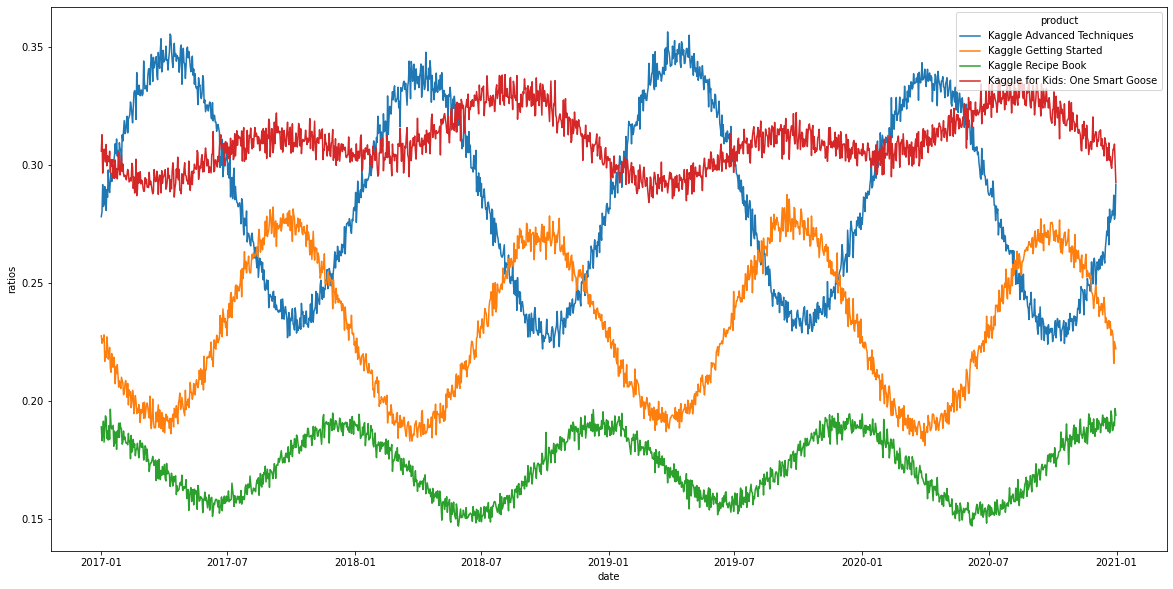

In [39]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = product_ratio_daily, x="date", y="ratios", hue="product");

# Preprocessing

In [49]:
data = train.append(test)

In [51]:
data = data.assign(day_month = lambda df_ : df_.date.dt.day
            ,month = lambda df_ : df_.date.dt.month
            ,year = lambda df_ : df_.date.dt.year
            ,day_week = lambda df_ : df_.date.dt.dayofweek
            ,day_year = lambda df_ : df_.date.dt.dayofyear
            ,is_weekend = lambda df_ : np.where(df_.day_week.isin([5,6]),1,0)
)

In [25]:
enc = OrdinalEncoder()
enc.fit(data[["country","store", "product"]])

OrdinalEncoder()

In [26]:
data[["country","store", "product"]] = enc.transform(data[["country", "store", "product"]])

In [27]:
SHIFT_DAY = 365

In [28]:
LAG_DAYS = [col for col in range(SHIFT_DAY,SHIFT_DAY+15)]
data = data.assign(**{
        '{}_lag_{}'.format(col, l): data.groupby(["country",'product'])[col].transform(lambda x: x.shift(l))
        for l in LAG_DAYS
        for col in ['num_sold']
    })

In [29]:
print('Create rolling aggs')

for i in [7,14,30,60,180]:
    print('Rolling period:', i)
    data['rolling_mean_'+str(i)] = data.groupby(["country",'store','product'])['num_sold'].transform(lambda x: x.shift(SHIFT_DAY).rolling(i).mean()).astype(np.float16)
    data['rolling_std_'+str(i)]  = data.groupby(["country",'store','product'])['num_sold'].transform(lambda x: x.shift(SHIFT_DAY).rolling(i).std()).astype(np.float16)

Create rolling aggs
Rolling period: 7
Rolling period: 14
Rolling period: 30
Rolling period: 60
Rolling period: 180


In [30]:
enc.categories_

[array(['Belgium', 'France', 'Germany', 'Italy', 'Poland', 'Spain'],
       dtype=object),
 array(['KaggleMart', 'KaggleRama'], dtype=object),
 array(['Kaggle Advanced Techniques', 'Kaggle Getting Started',
        'Kaggle Recipe Book', 'Kaggle for Kids: One Smart Goose'],
       dtype=object)]

In [31]:
holidays_mapping = {0.0 : 'BE', 1.0 : 'FR', 2.0 : 'DE', 3.0 : 'IT', 4.0 : 'PL', 5.0 : 'ES'}

In [32]:
data['iso_country'] = data.country.map(holidays_mapping)

In [33]:
data['is_holiday'] = data.apply(lambda x: int(x.date in holidays.country_holidays(x['iso_country'])), axis=1)

# Model

In [50]:
final_data = data.drop(columns=['row_id','date','day_month', 'iso_country'])

In [51]:
final_test = final_data[final_data.num_sold.isna()]
pre_train = final_data[~final_data.num_sold.isna()]
final_eval = pre_train[pre_train.year == 2020]
final_train = pre_train[~(pre_train.year == 2020)]

In [52]:
y_train = final_train.num_sold
y_eval = final_eval.num_sold
X_eval = final_eval.drop(columns='num_sold')
X_train = final_train.drop(columns='num_sold')
X_test = final_test.drop(columns='num_sold')

In [54]:
y_train_final = pre_train.num_sold
X_train_final = pre_train.drop(columns='num_sold')

In [55]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_eval, y_eval, reference=lgb_train)
lgb_train_final = lgb.Dataset(X_train_final, y_train_final)

In [56]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'mse',
    'metric': ['rmse', 'mape'],
    'n_estimators':300,
#     'num_leaves': 31,
    'learning_rate': 0.03,
#      'feature_fraction': 0.8,
#      'bagging_fraction': 0.8,
#      'bagging_freq': 1,
    'verbose': -1
}

In [57]:
gbm = lgb.train(params,
                lgb_train,
                valid_sets=[lgb_train,lgb_eval],
                verbose_eval=50,
                early_stopping_rounds=50)

C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 38.7654	training's mape: 0.260978	valid_1's rmse: 76.8938	valid_1's mape: 0.231905
[100]	training's rmse: 22.244	training's mape: 0.121068	valid_1's rmse: 74.5415	valid_1's mape: 0.21626
Early stopping, best iteration is:
[84]	training's rmse: 25.1476	training's mape: 0.146172	valid_1's rmse: 74.3659	valid_1's mape: 0.214204


In [58]:
# [71]	training's rmse: 27.7756	training's mape: 0.171371	valid_1's rmse: 79.4753	valid_1's mape: 0.225181

In [60]:
predictions = gbm.predict(X_eval)

In [61]:
X_eval_2 = X_eval.copy()
X_eval_2['predictions'] = predictions
X_eval_2['date'] = data[data.year==2020].date
X_eval_2['num_sold'] = y_eval

In [62]:
muestra = X_eval_2[(X_eval_2['product']==0) & (X_eval_2.store==0) & (X_eval_2.country==0)]

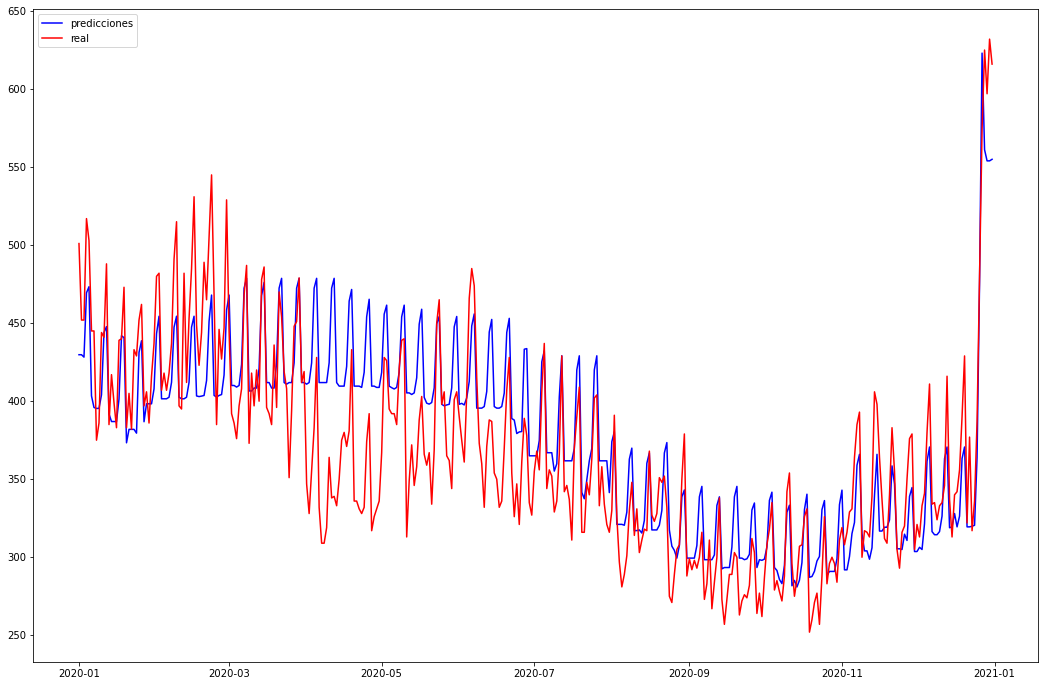

In [63]:
plt.figure(figsize=(18,12))
plt.plot(muestra.date, muestra.predictions, color='blue', label='predicciones')
plt.plot(muestra.date, muestra.num_sold, color='red', label='real')
plt.legend()
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

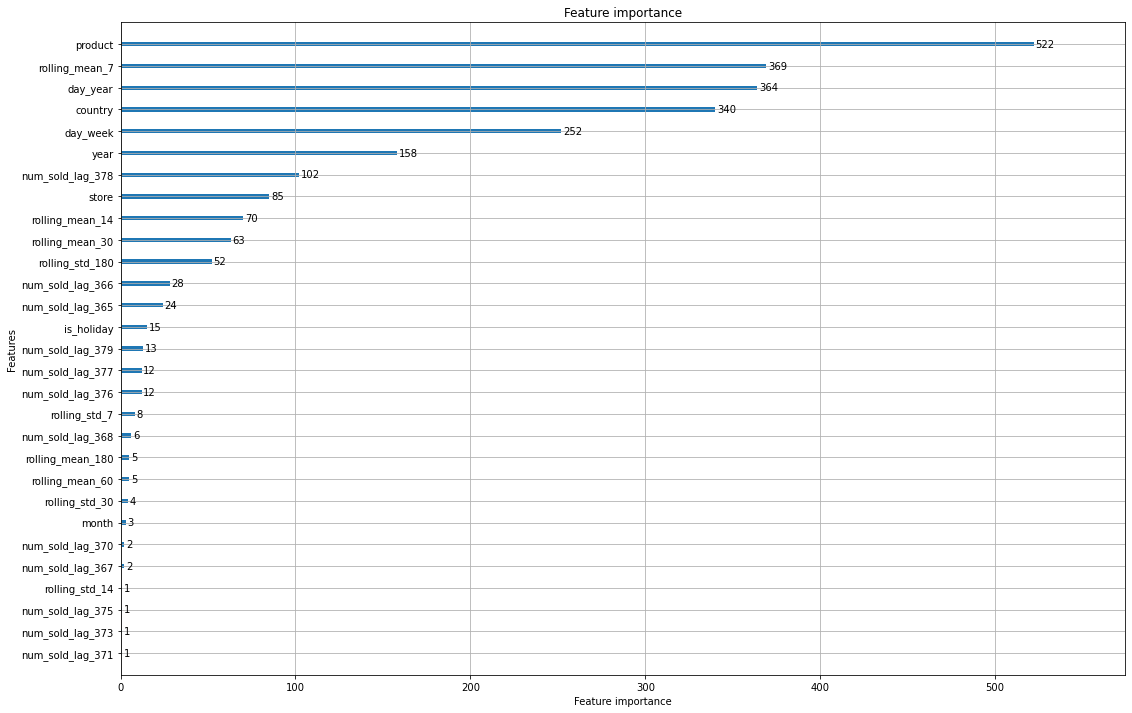

In [64]:
lgb.plot_importance(gbm,figsize=(18,12))

# Optuna Trial

In [74]:
def objective(trial):
#     data, target = sklearn.datasets.load_breast_cancer(return_X_y=True)
#     train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25)
#     dtrain = lgb.Dataset(train_x, label=train_y)

    final_param = {
        "objective": "mse",
        "metric": "mape",
        "verbosity": -1,
        "boosting_type": "gbdt",
        'n_estimators' : trial.suggest_int("n_estimators", 50, 500),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
#         "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.train(final_param, lgb_train)
    preds = gbm.predict(X_eval)
#     pred_labels = np.rint(preds)
    accuracy = mean_absolute_percentage_error(y_eval, preds)
    return accuracy

In [75]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2022-09-20 21:40:54,561] A new study created in memory with name: no-name-3ae3cd38-ad55-4f2c-930d-5e57372b0c4c
[I 2022-09-20 21:40:54,750] Trial 0 finished with value: 0.22446789708168957 and parameters: {'n_estimators': 87, 'lambda_l1': 1.0496268317507202, 'lambda_l2': 0.010078342589885044, 'num_leaves': 26, 'feature_fraction': 0.4096709469594759, 'bagging_fraction': 0.6039380675319264, 'bagging_freq': 5}. Best is trial 0 with value: 0.22446789708168957.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-20 21:40:57,047] Trial 1 finished with value: 0.23640917323974833 and parameters: {'n_estimators': 374, 'lambda_l1': 1.3197638612726224, 'lambda_l2': 0.0002244848231900162, 'num_leaves': 134, 'feature_fraction': 0.788135857388911, 'bagging_fraction': 0.5988069879575109, 'bagging_freq': 1}. Best is tri

[I 2022-09-20 21:41:11,304] Trial 14 finished with value: 0.22888802125427557 and parameters: {'n_estimators': 176, 'lambda_l1': 9.326869526767737, 'lambda_l2': 0.025659692100909175, 'num_leaves': 38, 'feature_fraction': 0.40078430507267077, 'bagging_fraction': 0.6383085297120704, 'bagging_freq': 5}. Best is trial 11 with value: 0.22013286537010615.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-20 21:41:11,483] Trial 15 finished with value: 0.22295423597321892 and parameters: {'n_estimators': 57, 'lambda_l1': 6.168880910916919e-07, 'lambda_l2': 0.00010525329989178282, 'num_leaves': 40, 'feature_fraction': 0.5033563004965188, 'bagging_fraction': 0.5142655793948661, 'bagging_freq': 7}. Best is trial 11 with value: 0.22013286537010615.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177:

[I 2022-09-20 21:41:18,872] Trial 28 finished with value: 0.22865118653005911 and parameters: {'n_estimators': 83, 'lambda_l1': 0.002294132175849692, 'lambda_l2': 0.000417184860801517, 'num_leaves': 162, 'feature_fraction': 0.444859506151535, 'bagging_fraction': 0.45785081531224486, 'bagging_freq': 6}. Best is trial 11 with value: 0.22013286537010615.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-20 21:41:19,948] Trial 29 finished with value: 0.23005069657039878 and parameters: {'n_estimators': 279, 'lambda_l1': 0.264367877051256, 'lambda_l2': 0.00015831314343794022, 'num_leaves': 72, 'feature_fraction': 0.5162843878856175, 'bagging_fraction': 0.5920229883709358, 'bagging_freq': 7}. Best is trial 11 with value: 0.22013286537010615.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: 

[I 2022-09-20 21:41:27,738] Trial 42 finished with value: 0.22629102983391106 and parameters: {'n_estimators': 85, 'lambda_l1': 6.038637161708128e-08, 'lambda_l2': 4.194653023906142, 'num_leaves': 73, 'feature_fraction': 0.4909173053223785, 'bagging_fraction': 0.5484174781971404, 'bagging_freq': 4}. Best is trial 11 with value: 0.22013286537010615.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-20 21:41:28,061] Trial 43 finished with value: 0.2257755938535687 and parameters: {'n_estimators': 70, 'lambda_l1': 1.8624177433717683e-07, 'lambda_l2': 2.48078543095318, 'num_leaves': 95, 'feature_fraction': 0.4513929698294267, 'bagging_fraction': 0.5054579794823748, 'bagging_freq': 7}. Best is trial 11 with value: 0.22013286537010615.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWa

[I 2022-09-20 21:41:33,218] Trial 56 finished with value: 0.2262588757300475 and parameters: {'n_estimators': 114, 'lambda_l1': 1.9996523882411344e-06, 'lambda_l2': 0.06707337845776794, 'num_leaves': 27, 'feature_fraction': 0.4932595669904348, 'bagging_fraction': 0.6536854123044791, 'bagging_freq': 7}. Best is trial 11 with value: 0.22013286537010615.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-20 21:41:33,355] Trial 57 finished with value: 0.2676221677499878 and parameters: {'n_estimators': 244, 'lambda_l1': 1.982545846118721e-08, 'lambda_l2': 3.069882643045077e-07, 'num_leaves': 2, 'feature_fraction': 0.5385539600299875, 'bagging_fraction': 0.47116356827671685, 'bagging_freq': 7}. Best is trial 11 with value: 0.22013286537010615.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177

[I 2022-09-20 21:41:36,591] Trial 70 finished with value: 0.2181294311153596 and parameters: {'n_estimators': 50, 'lambda_l1': 0.0003757838571475684, 'lambda_l2': 3.651973139888205e-08, 'num_leaves': 26, 'feature_fraction': 0.4149288584153836, 'bagging_fraction': 0.47574760951976053, 'bagging_freq': 7}. Best is trial 70 with value: 0.2181294311153596.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-20 21:41:36,763] Trial 71 finished with value: 0.22342905460769577 and parameters: {'n_estimators': 74, 'lambda_l1': 0.0002444652939980925, 'lambda_l2': 3.868856849678248e-08, 'num_leaves': 27, 'feature_fraction': 0.41389508872784064, 'bagging_fraction': 0.40347277309759483, 'bagging_freq': 7}. Best is trial 70 with value: 0.2181294311153596.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:17

[I 2022-09-20 21:41:39,082] Trial 84 finished with value: 0.2233282733319993 and parameters: {'n_estimators': 70, 'lambda_l1': 0.00035629264161531423, 'lambda_l2': 3.3836542144465916e-08, 'num_leaves': 20, 'feature_fraction': 0.45412604570510695, 'bagging_fraction': 0.4218682966058421, 'bagging_freq': 6}. Best is trial 72 with value: 0.2168470336754325.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-20 21:41:39,203] Trial 85 finished with value: 0.22892433046739133 and parameters: {'n_estimators': 93, 'lambda_l1': 0.00010827996499854555, 'lambda_l2': 1.940294115415293e-08, 'num_leaves': 7, 'feature_fraction': 0.5266617708344001, 'bagging_fraction': 0.44294209575929616, 'bagging_freq': 6}. Best is trial 72 with value: 0.2168470336754325.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:1

[I 2022-09-20 21:41:43,018] Trial 98 finished with value: 0.23046752066336315 and parameters: {'n_estimators': 98, 'lambda_l1': 8.777941850399345e-05, 'lambda_l2': 9.325469922903746e-07, 'num_leaves': 234, 'feature_fraction': 0.46518469186278794, 'bagging_fraction': 0.42638336357904194, 'bagging_freq': 7}. Best is trial 72 with value: 0.2168470336754325.
C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-20 21:41:43,979] Trial 99 finished with value: 0.23215163847057993 and parameters: {'n_estimators': 499, 'lambda_l1': 3.476698556821929e-05, 'lambda_l2': 5.273972890972313e-08, 'num_leaves': 22, 'feature_fraction': 0.502267334500406, 'bagging_fraction': 0.4504958579733406, 'bagging_freq': 1}. Best is trial 72 with value: 0.2168470336754325.


# Create submission

In [ ]:
final_params = {
    'boosting_type': 'gbdt',
    'objective': 'mse',
    'metric': ['rmse', 'mape'],
#     'n_estimators':300,
#     'num_leaves': 31,
    'learning_rate': 0.03,
#      'feature_fraction': 0.8,
#      'bagging_fraction': 0.8,
#      'bagging_freq': 1,
    'verbose': -1,
    'n_estimators':100,
    
}

In [ ]:
gbm_final = lgb.train(params,
                lgb_train_final)

In [ ]:
submission = gbm_final.predict(X_test)

In [ ]:
data = {'row_id': np.arange(70128,87648),
        'num_sold': submission
        }

In [ ]:
final_submission = pd.DataFrame(data)

In [ ]:
final_submission.to_csv('./data/final_submission.csv', index=False)